In [1]:
import os
import copy
import pickle
import sympy
import dowhy
import functools
import itertools
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import choice
from error_injection import MissingValueError
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange, tqdm
from dowhy import CausalModel
from dowhy import causal_estimators
import dowhy.datasets
from IPython.display import display, clear_output

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [3]:
symbol_id = -1
scaler_symbols = set([sb(f'k{i}') for i in range(100)])
linearization_dict = dict()
reverse_linearization_dict = dict()


def compute_closed_form(X, y):
    return np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))


def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


def sample_data(imputed_datasets, uncert_inds=[], seed=42):
    imp_np = np.array(imputed_datasets)
    if len(uncert_inds) == 0:
        uncert_inds = list(itertools.product(range(imp_np.shape[1]),range(imp_np.shape[2])))
    np.random.seed(seed)
    choices = np.random.choice(np.arange(imp_np.shape[0]), len(uncert_inds), replace=True)
    sample_result = imputed_datasets[0].copy()
    for i, ind in enumerate(uncert_inds):
        sample_result[ind[0]][ind[1]] = imputed_datasets[choices[i]][ind[0]][ind[1]]
    return sample_result


def linearization(expr_ls):
    processed_expr_ls = [0 for _ in range(len(expr_ls))]
    for expr_id, expr in enumerate(expr_ls):
        # Do not support monomial expr currently, e.g., expr = 1.5*e1. 
        # At lease two monomials in expr, e.g., expr = 1.5*e1 + 2.
        if not(expr.free_symbols):
            processed_expr_ls[expr_id] += expr
            continue
        expr = expr.expand()
        for arg in expr.args:
            if not(arg.free_symbols):
                processed_expr_ls[expr_id] += arg
                continue
            p = arg.as_poly()
            monomial_exponents = p.monoms()[0]
            
            # only deal with non-linear monomials (order > 2)
            if sum(monomial_exponents) <= 1:
                processed_expr_ls[expr_id] += arg
                continue

            monomial = sympy.prod(x**k for x, k in zip(p.gens, monomial_exponents) 
                                  if not(x in scaler_symbols))
            # check global substitution dictionary
            if monomial in linearization_dict:
                processed_expr_ls[expr_id] += arg.coeff(monomial)*linearization_dict[monomial]
            else:
                found = False
                subs_monomial = create_symbol()
                for symb in monomial.free_symbols:
                    if symb in reverse_linearization_dict:
                        equivalent_monomial = monomial.subs(symb, reverse_linearization_dict[symb])
                        if equivalent_monomial in linearization_dict:
                            subs_monomial = linearization_dict[equivalent_monomial]
                            found = True
                            break
                linearization_dict[monomial] = subs_monomial
                if not(found):
                    reverse_linearization_dict[subs_monomial] = monomial
                processed_expr_ls[expr_id] += arg.coeff(monomial)*subs_monomial
                
    return processed_expr_ls


def merge_small_components_pca(expr_ls, budget=10):
    if not(isinstance(expr_ls, sympy.Expr)):
        expr_ls = sympy.Matrix(expr_ls)
    if expr_ls.free_symbols:
        center = expr_ls.subs(dict([(symb, 0) for symb in expr_ls.free_symbols]))
    else:
        return expr_ls
    monomials_dict = get_generators(expr_ls)
    generators = np.array([monomials_dict[m] for m in monomials_dict])
    if len(generators) <= budget:
        return expr_ls
    monomials = [m for m in monomials_dict]
    pca = PCA(n_components=len(generators[0]))
    pca.fit(np.concatenate([generators, -generators]))
    transformed_generators = pca.transform(generators)
    transformed_generator_norms = np.linalg.norm(transformed_generators, axis=1, ord=2)
    # from largest to lowest norm
    sorted_indices = transformed_generator_norms.argsort()[::-1].astype(int)
    sorted_transformed_generators = transformed_generators[sorted_indices]
    sorted_monomials = [monomials[idx] for idx in sorted_indices]
    new_transformed_generators = np.concatenate([sorted_transformed_generators[:budget], 
                                                 np.diag(np.sum(np.abs(sorted_transformed_generators[budget:]), 
                                                                axis=0))])
    new_generators = pca.inverse_transform(new_transformed_generators)
    new_monomials = sorted_monomials[:budget] + [create_symbol() for _ in range(len(generators[0]))]
    
    processed_expr_ls = center
    for monomial_id in range(len(new_monomials)):
        processed_expr_ls += sympy.Matrix(new_generators[monomial_id])*new_monomials[monomial_id]
    
    return processed_expr_ls


def get_vertices(affset):
    l = len(affset)
    distinct_symbols = set()
    for expr in affset:
        if not(isinstance(expr, sympy.Expr)):
            assert isinstance(expr, int) or isinstance(expr, float)
        else:
            if distinct_symbols:
                distinct_symbols = distinct_symbols.union(expr.free_symbols)
            else:
                distinct_symbols = expr.free_symbols
    distinct_symbols = list(distinct_symbols)
    # print(distinct_symbols)
    combs = [list(zip(distinct_symbols,list(l))) for l in list(itertools.product([-1, 1], repeat=len(distinct_symbols)))]
    res = set()
    for assignment in combs:
        res.add(tuple([expr.subs(assignment) for expr in affset]))
    return(res)


# take a list of expressions as input, output the list of monomials and generator vectors,
def get_generators(expr_ls):
    monomials = dict()
    for expr_id, expr in enumerate(expr_ls):
        if not(isinstance(expr, sympy.Expr)) or not(expr.free_symbols):
            continue
        expr = expr.expand()
        p = sympy.Poly(expr)
        monomials_in_expr = [sympy.prod(x**k for x, k in zip(p.gens, mon)) 
                             for mon in p.monoms() if sum(mon) >= 1]
        for monomial in monomials_in_expr:
            coef = float(p.coeff_monomial(monomial))
            if monomial in monomials:
                if len(monomials[monomial]) < expr_id:
                    monomials[monomial] = monomials[monomial] + [0 for _ in range(expr_id-len(monomials[monomial]))]
                monomials[monomial].append(coef)
            else:
                monomials[monomial] = [0 for _ in range(expr_id)] + [coef]

    for monomial in monomials:
        if len(monomials[monomial]) < len(expr_ls):
            monomials[monomial] = monomials[monomial] + [0 for _ in range(len(expr_ls)-len(monomials[monomial]))]
    
    return monomials


def plot_conretiztion(affset, alpha = 0.5, color='red', budget=-1, 
                      label='Ours', edgecolor=None, linewidth=1):
    if budget > -1:
        affset = merge_small_components_pca(affset, budget=budget)
    pts = np.array(list(map(list, get_vertices(affset))))
    hull = ConvexHull(pts)
    plt.fill(pts[hull.vertices,0], pts[hull.vertices,1], color, alpha=alpha, 
             label=label, edgecolor=edgecolor, linewidth=linewidth)

### Scenario 1

In [4]:
np.random.seed(0)
data = dowhy.datasets.linear_dataset(beta=0.5,
                                     num_common_causes=5,
                                     num_treatments=1,
                                     num_samples=100,
                                     treatment_is_binary=True,
                                     outcome_is_binary=False,
                                     stddev_treatment_noise=10,
                                    )
df = data["df"]
df['v0'] = df['v0'].astype(float)
df.corr()

,W0,W1,W2,W3,W4,v0,y
W0,1.000000,0.166709,0.067305,0.149616,-0.000326,0.205963,0.432444
W1,0.166709,1.000000,-0.012357,0.018416,0.097455,0.109692,0.398079
W2,0.067305,-0.012357,1.000000,0.048398,0.080499,0.025124,0.614620
W3,0.149616,0.018416,0.048398,1.000000,-0.193899,-0.034596,0.216934
W4,-0.000326,0.097455,0.080499,-0.193899,1.000000,0.081351,0.565829
v0,0.205963,0.109692,0.025124,-0.034596,0.081351,1.000000,0.375317
y,0.432444,0.398079,0.614620,0.216934,0.565829,0.375317,1.000000


In [5]:
# all_cols = ['treatment', 'gestat10', 'nprevistq', 'hydra', 'csex', 'incervix', 'dmar', 'mpre5', 'phyper']
all_cols = ['W0', 'W1', 'W2', 'W3', 'W4', 'v0']
all_cols_idx = [df.columns.to_list().index(c) for c in all_cols]

# num of errors injected
mv_num = 15

# which col to inject missing val
treatment_idx = all_cols.index('v0')
uncertain_attr = all_cols.index('W0')

# MNAR
def non_random_pattern(data_X, data_y):
    binary_indicators = []
    for i in range(data_X.shape[0]):
        if (data_X.iloc[i, treatment_idx] == 1) and (data_X.iloc[i, uncertain_attr] > 0):
            binary_indicators.append(1)
        else:
            binary_indicators.append(0)
    return np.array(binary_indicators)

sample_pattern_len = np.sum(non_random_pattern(df.drop('y', axis=1), df.y))
mv_ratio = mv_num/sample_pattern_len
mv_err = MissingValueError(uncertain_attr, pattern=non_random_pattern, ratio=mv_ratio)
dirty_df, dirty_y, _, _ = mv_err.inject(df.drop('y', axis=1).copy(), df.y.copy(), df.drop('y', axis=1), df.y)

X_extended = np.append(np.ones((len(dirty_df), 1)), 
                       dirty_df.to_numpy().astype(float)[:, all_cols_idx], axis=1)
X_extended_clean = np.append(np.ones((len(df), 1)), 
                             df.to_numpy().astype(float)[:, all_cols_idx], axis=1)

param_clean = compute_closed_form(X_extended_clean, dirty_y)

# first row becomes constant 1's
treatment_idx += 1
uncertain_attr += 1
# remain_col_idx = [0] + [i+1 for i in remain_col_idx]

In [6]:
imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), IterativeImputer(random_state=42)]

num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = [X_extended_clean[:, uncertain_attr]]
imputed_datasets = [X_extended_clean]
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
# X_extended_max = X_extended_max[:, remain_col_idx]

X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)
# X_extended_min = X_extended_min[:, remain_col_idx]

# X_extended = X_extended[:, remain_col_idx]

In [7]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)
yR = sympy.Matrix(dirty_y)
yS = yR*0.0

In [8]:
sample_params = []
for s in tqdm(range(1000), desc='Samples'):
    samp = sample_data(imputed_datasets, seed=s)
    sample_params.append(np.matmul(np.linalg.inv(np.matmul(samp.T, samp)), np.matmul(samp.T, dirty_y)))

sample_params_np = np.array(sample_params)

Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

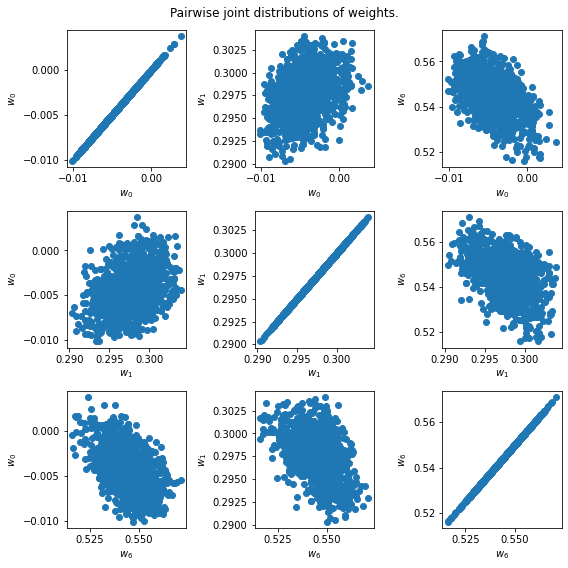

In [9]:
# joint distribution between different dims of coefs
fig = plt.figure(figsize=(8, 8))
cnt = 1
for i in [0, uncertain_attr, treatment_idx]:
    for j in [0, uncertain_attr, treatment_idx]:
        plt.subplot(3, 3, cnt)
        cnt += 1
        x_data = sample_params_np[:, i]
        y_data = sample_params_np[:, j]
        plt.scatter(x_data, y_data)
        plt.xlabel(f'$w_{i}$')
        plt.ylabel(f'$w_{j}$')
fig.suptitle('Pairwise joint distributions of weights.')
plt.tight_layout()
plt.show()

In [10]:
lr = 0.04
n = XR.shape[0]

VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V = sympy.Matrix(V)

wR = (XR.T*XR).inv()*XR.T*yR
wS_non_data = 0.0*V.row(0).T
for i in range(XR.shape[1]):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T

eigenvalues = 1 - sigma/n*2*lr
for eigenvalue in eigenvalues:
    assert abs(eigenvalue) <= 1

A = V.T*np.diag(eigenvalues)*V

wS_data = (np.identity(XR.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lr*2/n)

wS = wS_non_data + wS_data
w = wS + wR
w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
w_prime_projected = V*w_prime

eqs = []
for d in range(XR.shape[1]):
    eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(XR.shape[1]):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(XR.shape[1]):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
                break
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(XR.shape[1]):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

result = sympy.solve(eqs, [sb(f'k{i}') for i in range(XR.shape[1])])
for ki in result:
    assert result[ki] >= 0
param = wR + wS.subs(result)

In [11]:
result

In [12]:
sample_imputed_data_knn5 = imputed_datasets[1]
sample_param_knn5 = compute_closed_form(sample_imputed_data_knn5, dirty_y)

sample_imputed_data_knn10 = imputed_datasets[2]
sample_param_knn10 = compute_closed_form(sample_imputed_data_knn10, dirty_y)

sample_imputed_data_iter = imputed_datasets[3]
sample_param_iter = compute_closed_form(sample_imputed_data_iter, dirty_y)

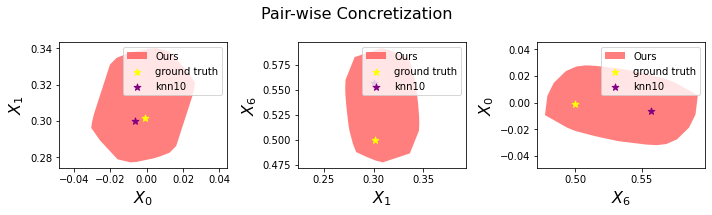

In [13]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[uncertain_attr]], 0.5, budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[0]], [param_clean[uncertain_attr]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[0]], [sample_param_knn5[1]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[0]], [sample_param_knn10[uncertain_attr]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[0]], [sample_param_iter[1]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(132)
plot_conretiztion([param[uncertain_attr], param[treatment_idx]], budget=10)
# plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[uncertain_attr]], [param_clean[treatment_idx]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[1]], [sample_param_knn5[5]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[uncertain_attr]], [sample_param_knn10[treatment_idx]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[1]], [sample_param_iter[5]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.ylabel(f'$X_{treatment_idx}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(133)
plot_conretiztion([param[treatment_idx], param[0]], budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[treatment_idx]], [param_clean[0]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[5]], [sample_param_knn5[0]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[treatment_idx]], [sample_param_knn10[0]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[5]], [sample_param_iter[0]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{treatment_idx}$', fontsize=16)
plt.ylabel('$X_0$', fontsize=16)
plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.legend()
plt.tight_layout()

In [14]:
scenario_dict = dict()
scenario_dict[1] = dict()
scenario_dict[1]['param'] = copy.deepcopy(param)
scenario_dict[1]['param_clean'] = copy.deepcopy(param_clean)
scenario_dict[1]['sample_param_knn10'] = copy.deepcopy(sample_param_knn10)

### Scenario 2

In [15]:
np.random.seed(0)
data = dowhy.datasets.linear_dataset(beta=0.02,
                                     num_common_causes=5,
                                     num_treatments=1,
                                     num_samples=100,
                                     treatment_is_binary=True,
                                     outcome_is_binary=False,
                                     stddev_treatment_noise=10,
                                    )
df = data["df"]
df['v0'] = df['v0'].astype(float)
df.corr()

,W0,W1,W2,W3,W4,v0,y
W0,1.000000,0.166709,0.067305,0.149616,-0.000326,0.205963,0.410033
W1,0.166709,1.000000,-0.012357,0.018416,0.097455,0.109692,0.397649
W2,0.067305,-0.012357,1.000000,0.048398,0.080499,0.025124,0.648620
W3,0.149616,0.018416,0.048398,1.000000,-0.193899,-0.034596,0.239804
W4,-0.000326,0.097455,0.080499,-0.193899,1.000000,0.081351,0.583367
v0,0.205963,0.109692,0.025124,-0.034596,0.081351,1.000000,0.155613
y,0.410033,0.397649,0.648620,0.239804,0.583367,0.155613,1.000000


In [16]:
# all_cols = ['treatment', 'gestat10', 'nprevistq', 'hydra', 'csex', 'incervix', 'dmar', 'mpre5', 'phyper']
all_cols = ['W0', 'W1', 'W2', 'W3', 'W4', 'v0']
all_cols_idx = [df.columns.to_list().index(c) for c in all_cols]

# num of errors injected
mv_num = 15

# which col to inject missing val
treatment_idx = all_cols.index('v0')
uncertain_attr = all_cols.index('W0')

# MNAR
def non_random_pattern(data_X, data_y):
    binary_indicators = []
    for i in range(data_X.shape[0]):
        if (data_X.iloc[i, treatment_idx] == 0) and (data_X.iloc[i, uncertain_attr] > 0):
            binary_indicators.append(1)
        else:
            binary_indicators.append(0)
    return np.array(binary_indicators)

sample_pattern_len = np.sum(non_random_pattern(df.drop('y', axis=1), df.y))
mv_ratio = mv_num/sample_pattern_len
print(mv_ratio)
mv_err = MissingValueError(uncertain_attr, pattern=non_random_pattern, ratio=mv_ratio)
dirty_df, dirty_y, _, _ = mv_err.inject(df.drop('y', axis=1).copy(), df.y.copy(), df.drop('y', axis=1), df.y)

X_extended = np.append(np.ones((len(dirty_df), 1)), 
                       dirty_df.to_numpy().astype(float)[:, all_cols_idx], axis=1)
X_extended_clean = np.append(np.ones((len(df), 1)), 
                             df.to_numpy().astype(float)[:, all_cols_idx], axis=1)

param_clean = compute_closed_form(X_extended_clean, dirty_y)

# first row becomes constant 1's
treatment_idx += 1
uncertain_attr += 1
# remain_col_idx = [0] + [i+1 for i in remain_col_idx]

0.625


In [17]:
imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), IterativeImputer(random_state=42)]

num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = [X_extended_clean[:, uncertain_attr]]
imputed_datasets = [X_extended_clean]
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
# X_extended_max = X_extended_max[:, remain_col_idx]

X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)
# X_extended_min = X_extended_min[:, remain_col_idx]

# X_extended = X_extended[:, remain_col_idx]

In [18]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)
yR = sympy.Matrix(dirty_y)
yS = yR*0.0

In [19]:
sample_params = []
for s in tqdm(range(1000), desc='Samples'):
    samp = sample_data(imputed_datasets, seed=s)
    sample_params.append(np.matmul(np.linalg.inv(np.matmul(samp.T, samp)), np.matmul(samp.T, dirty_y)))

sample_params_np = np.array(sample_params)

Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

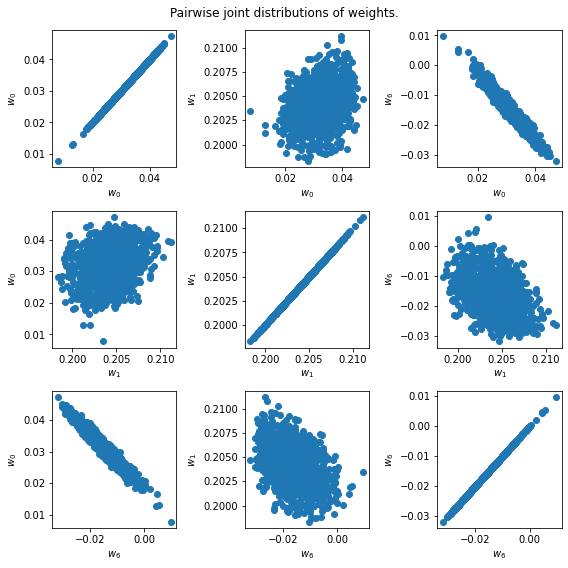

In [20]:
# joint distribution between different dims of coefs
fig = plt.figure(figsize=(8, 8))
cnt = 1
for i in [0, uncertain_attr, treatment_idx]:
    for j in [0, uncertain_attr, treatment_idx]:
        plt.subplot(3, 3, cnt)
        cnt += 1
        x_data = sample_params_np[:, i]
        y_data = sample_params_np[:, j]
        plt.scatter(x_data, y_data)
        plt.xlabel(f'$w_{i}$')
        plt.ylabel(f'$w_{j}$')
fig.suptitle('Pairwise joint distributions of weights.')
plt.tight_layout()
plt.show()

In [21]:
lr = 0.04
n = XR.shape[0]

VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V = sympy.Matrix(V)

wR = (XR.T*XR).inv()*XR.T*yR
wS_non_data = 0.0*V.row(0).T
for i in range(XR.shape[1]):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T

eigenvalues = 1 - sigma/n*2*lr
for eigenvalue in eigenvalues:
    assert abs(eigenvalue) <= 1

A = V.T*np.diag(eigenvalues)*V

wS_data = (np.identity(XR.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lr*2/n)

wS = wS_non_data + wS_data
w = wS + wR
w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
w_prime_projected = V*w_prime

eqs = []
for d in range(XR.shape[1]):
    eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(XR.shape[1]):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(XR.shape[1]):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
                break
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(XR.shape[1]):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

result = sympy.solve(eqs, [sb(f'k{i}') for i in range(XR.shape[1])])
for ki in result:
    assert result[ki] >= 0
param = wR + wS.subs(result)

In [22]:
result

In [23]:
sample_imputed_data_knn5 = imputed_datasets[1]
sample_param_knn5 = compute_closed_form(sample_imputed_data_knn5, dirty_y)

sample_imputed_data_knn10 = imputed_datasets[2]
sample_param_knn10 = compute_closed_form(sample_imputed_data_knn10, dirty_y)

sample_imputed_data_iter = imputed_datasets[3]
sample_param_iter = compute_closed_form(sample_imputed_data_iter, dirty_y)

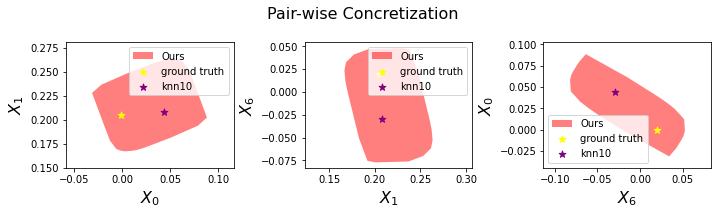

In [24]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[uncertain_attr]], 0.5, budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[0]], [param_clean[uncertain_attr]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[0]], [sample_param_knn5[1]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[0]], [sample_param_knn10[uncertain_attr]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[0]], [sample_param_iter[1]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(132)
plot_conretiztion([param[uncertain_attr], param[treatment_idx]], budget=10)
# plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[uncertain_attr]], [param_clean[treatment_idx]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[1]], [sample_param_knn5[5]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[uncertain_attr]], [sample_param_knn10[treatment_idx]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[1]], [sample_param_iter[5]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.ylabel(f'$X_{treatment_idx}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(133)
plot_conretiztion([param[treatment_idx], param[0]], budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[treatment_idx]], [param_clean[0]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[5]], [sample_param_knn5[0]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[treatment_idx]], [sample_param_knn10[0]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[5]], [sample_param_iter[0]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{treatment_idx}$', fontsize=16)
plt.ylabel('$X_0$', fontsize=16)
plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.legend()
plt.tight_layout()

In [25]:
scenario_dict[2] = dict()
scenario_dict[2]['param'] = copy.deepcopy(param)
scenario_dict[2]['param_clean'] = copy.deepcopy(param_clean)
scenario_dict[2]['sample_param_knn10'] = copy.deepcopy(sample_param_knn10)

### Scenario 3

In [26]:
np.random.seed(0)
data = dowhy.datasets.linear_dataset(beta=-0.5, num_common_causes=5, num_treatments=1, num_samples=100,
                                     treatment_is_binary=True, outcome_is_binary=False, 
                                     stddev_treatment_noise=10)
df = data["df"]
df['v0'] = df['v0'].astype(float)
df.corr()

,W0,W1,W2,W3,W4,v0,y
W0,1.000000,0.166709,0.067305,0.149616,-0.000326,0.205963,0.355741
W1,0.166709,1.000000,-0.012357,0.018416,0.097455,0.109692,0.369159
W2,0.067305,-0.012357,1.000000,0.048398,0.080499,0.025124,0.645219
W3,0.149616,0.018416,0.048398,1.000000,-0.193899,-0.034596,0.250410
W4,-0.000326,0.097455,0.080499,-0.193899,1.000000,0.081351,0.563624
v0,0.205963,0.109692,0.025124,-0.034596,0.081351,1.000000,-0.119711
y,0.355741,0.369159,0.645219,0.250410,0.563624,-0.119711,1.000000


In [40]:
# all_cols = ['treatment', 'gestat10', 'nprevistq', 'hydra', 'csex', 'incervix', 'dmar', 'mpre5', 'phyper']
all_cols = ['W0', 'W1', 'W2', 'W3', 'W4', 'v0']
all_cols_idx = [df.columns.to_list().index(c) for c in all_cols]

# num of errors injected
mv_num = 15

# which col to inject missing val
treatment_idx = all_cols.index('v0')
uncertain_attr = all_cols.index('W0')

# MNAR
def non_random_pattern(data_X, data_y):
    binary_indicators = []
    for i in range(data_X.shape[0]):
        if (data_X.iloc[i, treatment_idx] == 1) and (data_X.iloc[i, uncertain_attr] > 0):
            binary_indicators.append(1)
        else:
            binary_indicators.append(0)
    return np.array(binary_indicators)

sample_pattern_len = np.sum(non_random_pattern(df.drop('y', axis=1), df.y))
mv_ratio = mv_num/sample_pattern_len
mv_err = MissingValueError(uncertain_attr, pattern=non_random_pattern, ratio=mv_ratio)
dirty_df, dirty_y, _, _ = mv_err.inject(df.drop('y', axis=1).copy(), df.y.copy(), df.drop('y', axis=1), df.y)

X_extended = np.append(np.ones((len(dirty_df), 1)), 
                       dirty_df.to_numpy().astype(float)[:, all_cols_idx], axis=1)
X_extended_clean = np.append(np.ones((len(df), 1)), 
                             df.to_numpy().astype(float)[:, all_cols_idx], axis=1)

param_clean = compute_closed_form(X_extended_clean, dirty_y)

# first row becomes constant 1's
treatment_idx += 1
uncertain_attr += 1
# remain_col_idx = [0] + [i+1 for i in remain_col_idx]

In [41]:
imputers = [KNNImputer(n_neighbors=5), KNNImputer(n_neighbors=10), IterativeImputer(random_state=42)]

num_attrs = X_extended.shape[1]
X_nan = X_extended.copy()
imputed_cols = [X_extended_clean[:, uncertain_attr]]
imputed_datasets = [X_extended_clean]
for imp in imputers:
    imputed_dataset = imp.fit_transform(X_nan)
    imputed_datasets.append(imputed_dataset)
    imputed_cols.append(imputed_dataset[:, uncertain_attr])

X_extended_max = X_extended.copy()
X_extended_max[:, uncertain_attr] = np.max(imputed_cols, axis=0)
# X_extended_max = X_extended_max[:, remain_col_idx]

X_extended_min = X_extended.copy()
X_extended_min[:, uncertain_attr] = np.min(imputed_cols, axis=0)
# X_extended_min = X_extended_min[:, remain_col_idx]

# X_extended = X_extended[:, remain_col_idx]

In [42]:
# convert ranges into symbolic representation 
symbol_id = -1
symbolic_data = X_extended.tolist()
symbols_in_data = set()
symbol_to_position = dict()
XS = X_extended.tolist()
XR = X_extended.tolist()
for row in range(len(symbolic_data)):
    for col in range(len(symbolic_data[0])):
        xmin = X_extended_min[row][col]
        xmax = X_extended_max[row][col]
        if xmin != xmax:
            xmean = (xmax + xmin) / 2
            xradius = (xmax - xmin) / 2
            new_symbol = create_symbol()
            symbolic_data[row][col] = xmean + xradius*new_symbol
            XS[row][col] = xradius*new_symbol
            XR[row][col] = xmean
            symbols_in_data.add(new_symbol)
            symbol_to_position[new_symbol] = (row, col)
        else:
            XS[row][col] = 0
XS = sympy.Matrix(XS)
XR = sympy.Matrix(XR)
yR = sympy.Matrix(dirty_y)
yS = yR*0.0

In [43]:
sample_params = []
for s in tqdm(range(1000), desc='Samples'):
    samp = sample_data(imputed_datasets, seed=s)
    sample_params.append(np.matmul(np.linalg.inv(np.matmul(samp.T, samp)), np.matmul(samp.T, dirty_y)))

sample_params_np = np.array(sample_params)

Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

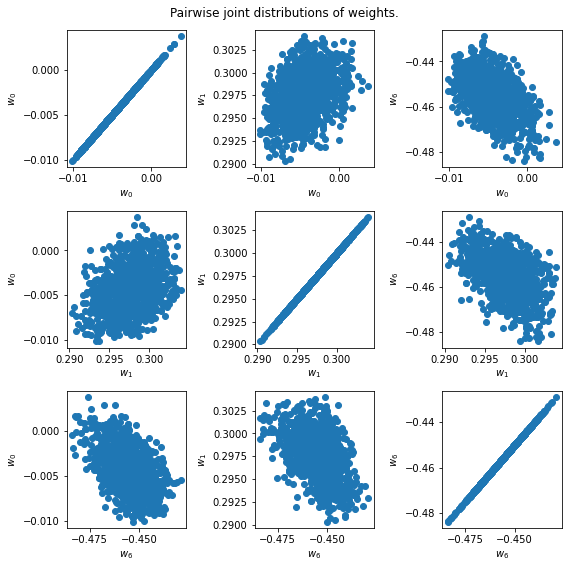

In [44]:
# joint distribution between different dims of coefs
fig = plt.figure(figsize=(8, 8))
cnt = 1
for i in [0, uncertain_attr, treatment_idx]:
    for j in [0, uncertain_attr, treatment_idx]:
        plt.subplot(3, 3, cnt)
        cnt += 1
        x_data = sample_params_np[:, i]
        y_data = sample_params_np[:, j]
        plt.scatter(x_data, y_data)
        plt.xlabel(f'$w_{i}$')
        plt.ylabel(f'$w_{j}$')
fig.suptitle('Pairwise joint distributions of weights.')
plt.tight_layout()
plt.show()

In [45]:
lr = 0.04
n = XR.shape[0]

VT, sigma, V = np.linalg.svd(np.array((XR.T*XR).tolist()).astype(float))
V = sympy.Matrix(V)

wR = (XR.T*XR).inv()*XR.T*yR
wS_non_data = 0.0*V.row(0).T
for i in range(XR.shape[1]):
    wS_non_data = wS_non_data + sb(f'k{i}')*sb(f'ep{i}')*V.row(i).T

eigenvalues = 1 - sigma/n*2*lr
for eigenvalue in eigenvalues:
    assert abs(eigenvalue) <= 1

A = V.T*np.diag(eigenvalues)*V

wS_data = (np.identity(XR.shape[1])-A).inv()*((XS.T*XR + XR.T*XS)*wR - XS.T*yR - XR.T*yS)*(-lr*2/n)

wS = wS_non_data + wS_data
w = wS + wR
w_prime = (-lr*2/n)*((XS.T*XR + XR.T*XS + XS.T*XS)*wS + XS.T*XS*wR - XS.T*yS).expand()
w_prime_projected = V*w_prime

eqs = []
for d in range(XR.shape[1]):
    eq1 = (1-abs(eigenvalues[d]))*sb(f'k{d}')
    eq2 = 0
    coef_dict = dict()
    coef_dict['const'] = 0
    for i in range(XR.shape[1]):
        coef_dict[sb(f'k{i}')] = 0
    for arg in w_prime_projected[d].args:
        contain_k = False
        for i in range(XR.shape[1]):
            symb_k = sb(f'k{i}')
            if symb_k in arg.free_symbols:
                coef_dict[symb_k] = coef_dict[symb_k] + abs(arg.args[0])
                contain_k = True
                break
        if not(contain_k):
            coef_dict['const'] = coef_dict['const'] + abs(arg.args[0])
    eq2 = coef_dict['const']
    for i in range(XR.shape[1]):
        eq2 = eq2 + sb(f'k{i}')*coef_dict[sb(f'k{i}')]
    eqs.append(sympy.Eq(eq1, eq2))

result = sympy.solve(eqs, [sb(f'k{i}') for i in range(XR.shape[1])])
for ki in result:
    assert result[ki] >= 0
param = wR + wS.subs(result)

In [46]:
result

In [47]:
sample_imputed_data_knn5 = imputed_datasets[1]
sample_param_knn5 = compute_closed_form(sample_imputed_data_knn5, dirty_y)

sample_imputed_data_knn10 = imputed_datasets[2]
sample_param_knn10 = compute_closed_form(sample_imputed_data_knn10, dirty_y)

sample_imputed_data_iter = imputed_datasets[3]
sample_param_iter = compute_closed_form(sample_imputed_data_iter, dirty_y)

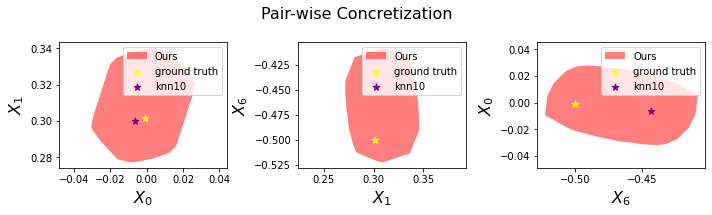

In [48]:
fig = plt.figure(figsize=(10, 3))
plt.subplot(131)
plot_conretiztion([param[0], param[uncertain_attr]], 0.5, budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[1] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[0]], [param_clean[uncertain_attr]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[0]], [sample_param_knn5[1]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[0]], [sample_param_knn10[uncertain_attr]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[0]], [sample_param_iter[1]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel('$X_0$', fontsize=16)
plt.ylabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(132)
plot_conretiztion([param[uncertain_attr], param[treatment_idx]], budget=10)
# plt.scatter([sp[1] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[uncertain_attr]], [param_clean[treatment_idx]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[1]], [sample_param_knn5[5]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[uncertain_attr]], [sample_param_knn10[treatment_idx]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[1]], [sample_param_iter[5]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{uncertain_attr}$', fontsize=16)
plt.ylabel(f'$X_{treatment_idx}$', fontsize=16)
plt.axis('equal')
plt.legend()

plt.subplot(133)
plot_conretiztion([param[treatment_idx], param[0]], budget=10)
# plt.scatter([sp[0] for sp in sample_params_np], [sp[2] for sp in sample_params_np], s=0.75)
plt.scatter([param_clean[treatment_idx]], [param_clean[0]], s=50, c='yellow', marker='*', label='ground truth')
# plt.scatter([sample_param_knn5[5]], [sample_param_knn5[0]], s=50, c='green', 
#             marker='*', label='knn5')
plt.scatter([sample_param_knn10[treatment_idx]], [sample_param_knn10[0]], s=50, c='purple', 
            marker='*', label='knn10')
# plt.scatter([sample_param_iter[5]], [sample_param_iter[0]], s=50, c='blue', 
#             marker='*', label='iter imputed')
plt.xlabel(f'$X_{treatment_idx}$', fontsize=16)
plt.ylabel('$X_0$', fontsize=16)
plt.axis('equal')
fig.suptitle('Pair-wise Concretization', fontsize=16)
plt.legend()
plt.tight_layout()

In [49]:
scenario_dict[3] = dict()
scenario_dict[3]['param'] = copy.deepcopy(param)
scenario_dict[3]['param_clean'] = copy.deepcopy(param_clean)
scenario_dict[3]['sample_param_knn10'] = copy.deepcopy(sample_param_knn10)

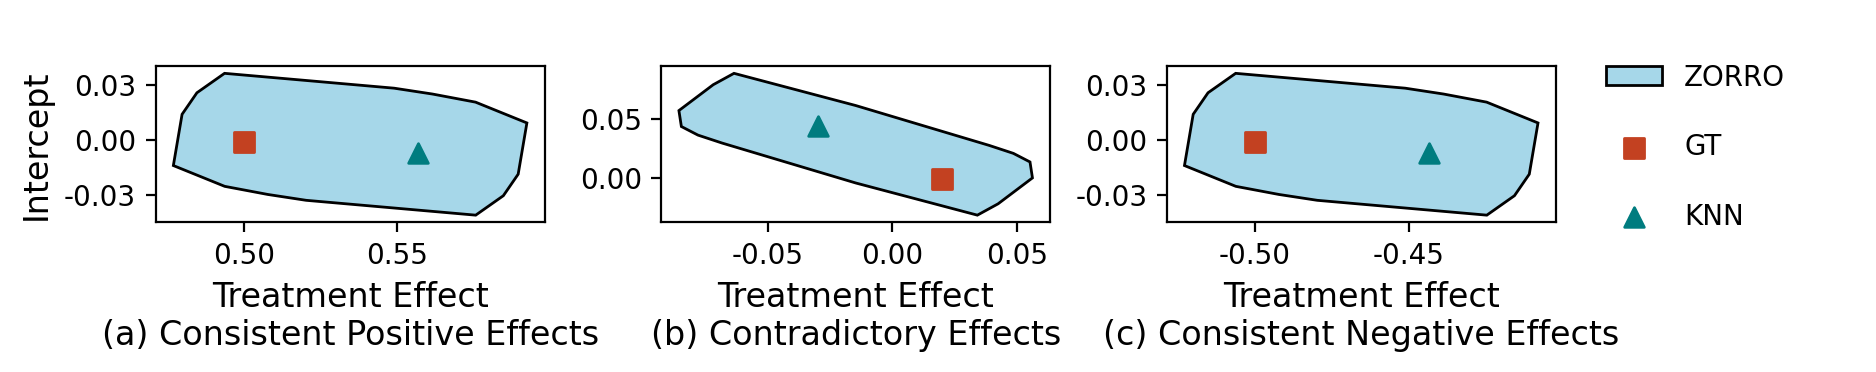

In [53]:
from matplotlib.ticker import FormatStrFormatter


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 1.3), dpi=200)

# Plot 1
for i in range(1, 4):
    param = scenario_dict[i]['param']
    param_clean = scenario_dict[i]['param_clean']
    sample_param_knn10 = scenario_dict[i]['sample_param_knn10']
    plt.subplot(1, 3, i)
    plot_conretiztion([param[treatment_idx], param[0]], budget=5, color='#A6D7E9', 
                      label='ZORRO', alpha=1, edgecolor='black', linewidth=1)
    plt.scatter([param_clean[treatment_idx]], [param_clean[0]], s=50, 
                c='#c34121', marker='s', label='GT')
    plt.scatter([sample_param_knn10[treatment_idx]], [sample_param_knn10[0]], s=50, c='#007c7f', 
                marker='^', label='KNN')
    ax = axes[i-1]
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==1:
        plt.ylabel('Intercept', fontsize=12)

axes[0].set_xlabel('Treatment Effect\n(a) Consistent Positive Effects', fontsize=12)
axes[1].set_xlabel('Treatment Effect\n(b) Contradictory Effects', fontsize=12)
axes[2].set_xlabel('Treatment Effect\n(c) Consistent Negative Effects', fontsize=12)

# Adjust layout
lines_labels = [axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.85, 0.35), ncol=1, labelspacing=1.5, frameon=False)

plt.subplots_adjust(wspace=0.3, top=0.9, bottom=0.3, left=0.1, right=0.8)
plt.savefig('causal-inference-example.pdf', bbox_inches='tight')